Feb 19 update (Jean): 
- implemented: verified PCA decomposition and also did PCA on the other grid id (heading 2)
- implemented: train/test split
- to implement 2: using vectors from 333519 to apply to 333346 and vice versa

# 1. Preprocessing and binning

In [25]:
# importing packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# be careful with that:
import warnings
warnings.filterwarnings('ignore')

In [26]:
# loading data and choosing grid

data_heatmap = pd.read_csv('../datasets/A_data_heatmap_300x250_3p.csv')
data_metrics = pd.read_csv('../datasets/A_data_domain_perf_metrics_300x250_3p.csv')

# choose between 333519, 333346

# grid_id = 333346
grid_id = 333519

In [27]:
# uncomment to visualize heatmap data
# data_heatmap

In [28]:
# expand table so that each row corresponds to 1 click:

data_heatmap_expanded = data_heatmap.loc[data_heatmap.index.repeat(data_heatmap['clicks'])].reset_index(drop=True)
data_heatmap_expanded['clicks'] = 1

click_stat = data_heatmap_expanded.groupby(['click_x','click_y'])['clicks'].count().reset_index()

In [29]:
# Binning clicks in nr_of_x_bins, nr_of_y_bins:

NR_OF_X_BINS = 61
NR_OF_Y_BINS = 51

max_width = data_heatmap['display_width'].max()
max_height = data_heatmap['display_height'].max()

width_bins = np.linspace(1, max_width, NR_OF_X_BINS)
height_bins = np.linspace(1, max_height, NR_OF_Y_BINS)

width_bins_max = len(width_bins)-2 # start at 0
height_bins_max = len(height_bins)-2

data_heatmap_expanded['click_x_bin'] = pd.cut(data_heatmap_expanded['click_x'], 
                                      bins = width_bins, 
                                      labels=False, 
                                      include_lowest=True)

data_heatmap_expanded['click_y_bin'] = pd.cut(data_heatmap_expanded['click_y'], 
                                      bins=height_bins, 
                                      labels=False, 
                                      include_lowest=True)


aggregated_clicks = data_heatmap_expanded.groupby(['grid_id',
                                           'domain', 
                                           'click_x_bin', 
                                           'click_y_bin']).size().reset_index(name='clicks_sum')


#aggregated_clicks['clicks_sum'].astype('int64');

In [30]:
# More binning: add empty bins --> easier to generate vectors
# takes a few seconds

from itertools import product

domains_grids = data_heatmap[['domain', 'grid_id']].drop_duplicates()

aux = pd.DataFrame(list(product(range(0,width_bins_max+1), 
                                range(0,height_bins_max+1))), 
                   columns=['click_x_bin', 'click_y_bin'])

domains_grids['key'] = 1
aux['key'] = 1

expanded_set = pd.merge(domains_grids, aux, on='key').drop('key', axis=1)

data_binned = pd.merge(expanded_set, aggregated_clicks, 
                  on = ['domain', 'grid_id', 'click_x_bin', 'click_y_bin'], 
                  how = 'left').fillna(0)
data_binned['clicks_sum'] = data_binned['clicks_sum'].astype('int64')
# data_binned = data_binned[data_binned['grid_id'] == 333519]

In [31]:
# data_binned['grid_id'].unique()

In [32]:
data_binned = data_binned[data_binned['grid_id'] == grid_id]

# 2. PCA code

In [33]:
# create a wide-format DataFrame such that each row corresponds to one heatmap
pivot_df = pd.pivot_table(data_binned, values='clicks_sum', index=['domain', 'grid_id'],
                           columns=['click_x_bin', 'click_y_bin'], aggfunc='sum', fill_value=0)

# Reset index to make 'domain' and 'grid_id' regular columns
pivot_df.reset_index(inplace=True)

# Rename columns to match the desired format
pivot_df.columns = ['domain', 'grid_id'] + [f'clicks_sum_for_{x}_{y}' for x, y in pivot_df.columns[2:]]

# Uncomment to view pivot_df
#print(pivot_df)

In [34]:
input = pivot_df.copy()


In [35]:
# Version 1 of normalizing
# Normalizing such that the total number of clicks in one heatmap sums to one. We do not standardize because standardization assumes the clicks follow a normal distribution, which is not the case
normalized_input = input.copy()

normalized_input.iloc[:,2:] = (input.iloc[:,2:].transpose()/input.iloc[:,2:].sum(axis=1)).transpose()

normalized_input.head()

,domain,grid_id,clicks_sum_for_0_0,clicks_sum_for_0_1,clicks_sum_for_0_2,clicks_sum_for_0_3,clicks_sum_for_0_4,clicks_sum_for_0_5,clicks_sum_for_0_6,clicks_sum_for_0_7,...,clicks_sum_for_59_40,clicks_sum_for_59_41,clicks_sum_for_59_42,clicks_sum_for_59_43,clicks_sum_for_59_44,clicks_sum_for_59_45,clicks_sum_for_59_46,clicks_sum_for_59_47,clicks_sum_for_59_48,clicks_sum_for_59_49
0,ID_1,333519,0.002732,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
1,ID_10,333519,0.032345,0.013477,0.008086,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
2,ID_1000,333519,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
3,ID_1002,333519,0.000000,0.000851,0.000425,0.000425,0.0,0.0,0.000851,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000425,0.0,0.000425,0.0
4,ID_1005,333519,0.000000,0.000581,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000581,0.0,0.000000,0.0,0.000581,0.0


In [36]:
# Version 2 of normalizing, same result as version 1
normalized_input_2 = input.copy()
normalized_input_2.iloc[:,2:] = normalized_input_2.iloc[:,2:].div(normalized_input_2.iloc[:,2:].sum(axis=1), axis=0)
normalized_input_2.head()

,domain,grid_id,clicks_sum_for_0_0,clicks_sum_for_0_1,clicks_sum_for_0_2,clicks_sum_for_0_3,clicks_sum_for_0_4,clicks_sum_for_0_5,clicks_sum_for_0_6,clicks_sum_for_0_7,...,clicks_sum_for_59_40,clicks_sum_for_59_41,clicks_sum_for_59_42,clicks_sum_for_59_43,clicks_sum_for_59_44,clicks_sum_for_59_45,clicks_sum_for_59_46,clicks_sum_for_59_47,clicks_sum_for_59_48,clicks_sum_for_59_49
0,ID_1,333519,0.002732,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
1,ID_10,333519,0.032345,0.013477,0.008086,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
2,ID_1000,333519,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
3,ID_1002,333519,0.000000,0.000851,0.000425,0.000425,0.0,0.0,0.000851,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000425,0.0,0.000425,0.0
4,ID_1005,333519,0.000000,0.000581,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000581,0.0,0.000000,0.0,0.000581,0.0


In [37]:
input['nb_clicks'] = input.iloc[:,  2:].sum(axis=1)
input.head()

,domain,grid_id,clicks_sum_for_0_0,clicks_sum_for_0_1,clicks_sum_for_0_2,clicks_sum_for_0_3,clicks_sum_for_0_4,clicks_sum_for_0_5,clicks_sum_for_0_6,clicks_sum_for_0_7,...,clicks_sum_for_59_41,clicks_sum_for_59_42,clicks_sum_for_59_43,clicks_sum_for_59_44,clicks_sum_for_59_45,clicks_sum_for_59_46,clicks_sum_for_59_47,clicks_sum_for_59_48,clicks_sum_for_59_49,nb_clicks
0,ID_1,333519,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,366
1,ID_10,333519,12,5,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,371
2,ID_1000,333519,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,378
3,ID_1002,333519,0,2,1,1,0,0,2,0,...,0,0,0,0,0,1,0,1,0,2351
4,ID_1005,333519,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,1720


In [38]:
# # Test code
# data = np.ones((5,  5))
# df = pd.DataFrame(data)
# df_nb = df.copy()
# df_nb['nb_clicks'] = df_nb.iloc[:,  2:].sum(axis=1)
# df_nb

In [39]:
# # Version 2 of normalizing
# df_2 = df.copy()
# df_2.iloc[:,2:] = df_2.iloc[:,2:].div(df_2.iloc[:,2:].sum(axis=1), axis=0)

# df_2.head()

In [40]:
# # Test code
# df_1 = df.copy()
# df_1.iloc[:,2:] = (df_1.iloc[:,2:].transpose()/df_1.iloc[:,2:].sum(axis=1)).transpose()
# df_1

In [41]:
# Plot explained variance ratio

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

features = normalized_input.columns[2:] #input.columns[1:]  # Exclude the first column, which is the index

# Select the number of components (in this case, reduce to 2 dimensions)
n_components = 200

# Instantiate the PCA model
# pca = PCA(n_components=n_components)

pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=n_components))])

# Fit and transform the data
pca_result = pipeline.fit_transform(normalized_input[features])

# Create a DataFrame with the PCA results
pca_df = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(n_components)])

# Concatenate the first column (index) from pca_input to pca_df
pca_df['domain'] = normalized_input['domain']

# Display the resulting DataFrame
#print(pca_df)

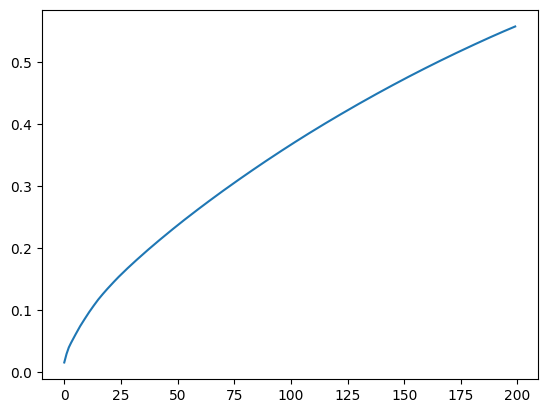

In [42]:
# Plot the cumulative explained variance ratio by the first k eigenvectors
pca_object = pipeline.named_steps['pca']
pca_exp_var = pca_object.explained_variance_ratio_
plt.plot(np.cumsum(pca_exp_var))

# print(sum(pca_exp_var[:2]))

In [43]:
# PCA to n = 2

features = normalized_input.columns[2:] #input.columns[1:]  # Exclude the first column, which is the index

# Select the number of components (in this case, reduce to 2 dimensions)
n_components = 2

# Instantiate the PCA model
# pca = PCA(n_components=n_components)

pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=n_components))])

# Fit and transform the data
pca_result = pipeline.fit_transform(normalized_input[features])

# Create a DataFrame with the PCA results
pca_df = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(n_components)])

# Concatenate the first column (index) from pca_input to pca_df
pca_df['domain'] = normalized_input['domain']

In [44]:
cb_333519 = ['ID_1184', 'ID_1281', 'ID_1305', 'ID_1353', 'ID_1448', 'ID_1522',
       'ID_1544', 'ID_162', 'ID_1682', 'ID_1690', 'ID_1824', 'ID_1888',
       'ID_1929', 'ID_2076', 'ID_2097', 'ID_2226', 'ID_2249', 'ID_2268',
       'ID_2331', 'ID_2339', 'ID_2386', 'ID_2396', 'ID_2438', 'ID_258',
       'ID_2609', 'ID_2680', 'ID_2863', 'ID_2883', 'ID_2908', 'ID_3061',
       'ID_3243', 'ID_3250', 'ID_3314', 'ID_3382', 'ID_3397', 'ID_3402',
       'ID_3420', 'ID_3459', 'ID_3470', 'ID_3540', 'ID_398', 'ID_409',
       'ID_484', 'ID_489', 'ID_526', 'ID_549', 'ID_580', 'ID_665',
       'ID_810', 'ID_84', 'ID_857', 'ID_86', 'ID_905', 'ID_927', 'ID_934',
       'ID_962', 'ID_986']

In [45]:
cb_333346 = ['ID_1247', 'ID_162', 'ID_2534', 'ID_2742', 'ID_526', 'ID_2201',
       'ID_1165', 'ID_743', 'ID_199', 'ID_2145', 'ID_2569', 'ID_643',
       'ID_1305', 'ID_3180', 'ID_3158', 'ID_136', 'ID_293', 'ID_1753',
       'ID_1849', 'ID_2226', 'ID_1462', 'ID_626', 'ID_2863', 'ID_3243',
       'ID_3250', 'ID_1708', 'ID_1238', 'ID_580', 'ID_84', 'ID_2568',
       'ID_2340', 'ID_1803', 'ID_3470', 'ID_139', 'ID_2619', 'ID_2908',
       'ID_1281', 'ID_3308', 'ID_2883', 'ID_1320', 'ID_1333', 'ID_1062',
       'ID_149', 'ID_260', 'ID_599', 'ID_1513', 'ID_3402', 'ID_1888',
       'ID_2972', 'ID_398', 'ID_2339', 'ID_1030', 'ID_3382', 'ID_2076',
       'ID_1646', 'ID_1077', 'ID_10', 'ID_1153', 'ID_1533', 'ID_2609',
       'ID_1214', 'ID_810', 'ID_2097', 'ID_2386', 'ID_1585', 'ID_549',
       'ID_3420', 'ID_3397', 'ID_2006', 'ID_561', 'ID_1542', 'ID_1570',
       'ID_1819', 'ID_1413', 'ID_1240', 'ID_793', 'ID_831', 'ID_3188',
       'ID_1437', 'ID_556', 'ID_1134', 'ID_314', 'ID_2836', 'ID_1483',
       'ID_2676', 'ID_665', 'ID_15', 'ID_2755', 'ID_2194', 'ID_1682',
       'ID_2775', 'ID_1923', 'ID_1846', 'ID_1262', 'ID_3314', 'ID_1448',
       'ID_1770', 'ID_2626', 'ID_3296', 'ID_489', 'ID_1963', 'ID_1268',
       'ID_1568', 'ID_1094', 'ID_2267', 'ID_409', 'ID_1650', 'ID_1522',
       'ID_927', 'ID_2302', 'ID_1929', 'ID_1435', 'ID_1353']

In [46]:
# Labelling points with ground truth

if grid_id == 333346:
    cb = cb_333346
elif grid_id == 333519:
    cb = cb_333519
pca_df['label'] = 0

pca_df.loc[pca_df.domain.isin(cb),'label'] = 1
pca_df['label'].sum()

57

In [47]:
print(grid_id)

333519


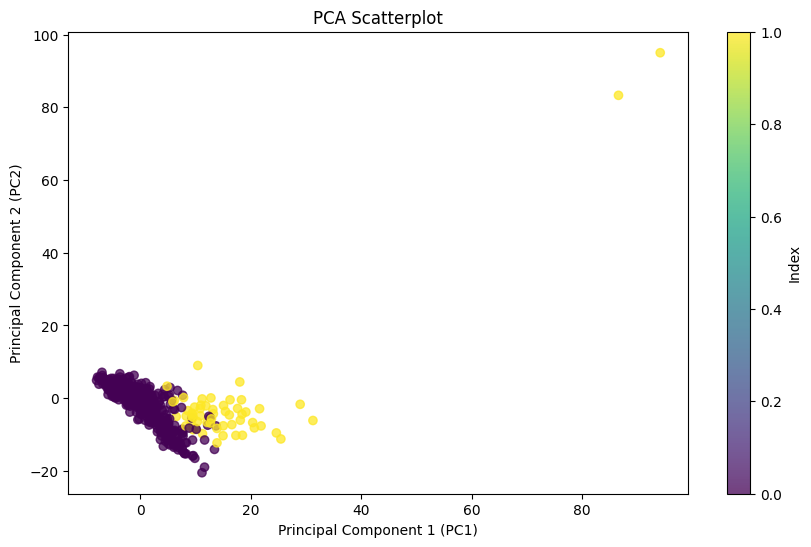

In [48]:
# Plotting pca_df with ground truth labels
pca_df1 = pca_df
plt.figure(figsize=(10, 6))
plt.scatter(pca_df1['PC1'], pca_df1['PC2'], c=pca_df1['label'], cmap='viridis', alpha=0.75)
plt.title('PCA Scatterplot')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.colorbar(label='Index')

plt.show()

# plt.savefig(f'PCA_gridid_{grid_id}.jpg')

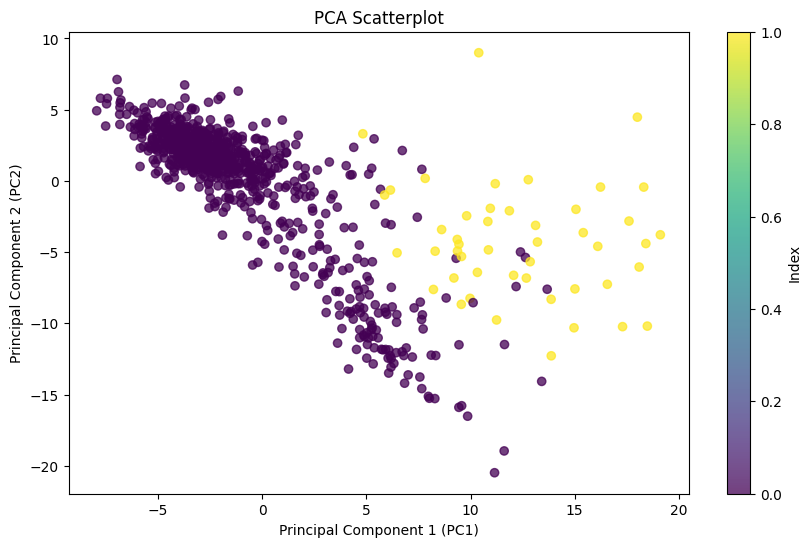

In [49]:
# Zoomed plot of pca_df with ground truth labels

pca_df1 = pca_df[pca_df.PC1<20]
plt.figure(figsize=(10, 6))
plt.scatter(pca_df1['PC1'], pca_df1['PC2'], c=pca_df1['label'], cmap='viridis', alpha=0.75)
plt.title('PCA Scatterplot')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.colorbar(label='Index')

# plt.show()

plt.savefig(f'PCA_gridid_{grid_id}.jpg')

# 3. Train-test split on 333519

In [70]:
print(grid_id)

333519


In [50]:
normalized_input['label'] = 0
normalized_input.loc[normalized_input.domain.isin(cb),'label'] = 1
normalized_input.head(10)

,domain,grid_id,clicks_sum_for_0_0,clicks_sum_for_0_1,clicks_sum_for_0_2,clicks_sum_for_0_3,clicks_sum_for_0_4,clicks_sum_for_0_5,clicks_sum_for_0_6,clicks_sum_for_0_7,...,clicks_sum_for_59_41,clicks_sum_for_59_42,clicks_sum_for_59_43,clicks_sum_for_59_44,clicks_sum_for_59_45,clicks_sum_for_59_46,clicks_sum_for_59_47,clicks_sum_for_59_48,clicks_sum_for_59_49,label
0,ID_1,333519,0.002732,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0
1,ID_10,333519,0.032345,0.013477,0.008086,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0
2,ID_1000,333519,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0
3,ID_1002,333519,0.000000,0.000851,0.000425,0.000425,0.000000,0.000000,0.000851,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000425,0.0,0.000425,0.000000,0
4,ID_1005,333519,0.000000,0.000581,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000581,0.000000,0.000000,0.0,0.000581,0.000000,0
5,ID_1010,333519,0.000000,0.000000,0.003861,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0
6,ID_1021,333519,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0
7,ID_1024,333519,0.000000,0.000000,0.000000,0.000000,0.000000,0.002320,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.002320,0
8,ID_1037,333519,0.000351,0.000176,0.000176,0.000351,0.000176,0.000351,0.000351,0.0,...,0.000176,0.0,0.000351,0.000351,0.000351,0.000176,0.0,0.000176,0.000176,0
9,ID_1040,333519,0.000000,0.000000,0.004405,0.000000,0.004405,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0


In [51]:
from sklearn.model_selection import train_test_split

X = normalized_input.iloc[:,2:-1]
y = normalized_input.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [73]:
print(y_train)

544    0
398    0
764    0
312    0
326    0
      ..
106    0
270    0
860    0
435    0
102    0
Name: label, Length: 697, dtype: int64


In [85]:
index = 0

while y_train.iloc[index] == 0:
    index += 1
    # y_train.iloc[index]

print(index)

12


In [76]:
n_components = 2

# Instantiate the PCA model
pca_train = PCA(n_components=n_components)

# Fit and transform the data
train_result = pca_train.fit_transform(X_train)

# Create a DataFrame with the PCA results
train_result_df = pd.DataFrame(data=train_result, columns=[f'PC{i+1}' for i in range(n_components)])

train_result_df.set_index(X_train.index)

# train_result_df['label'] = y_train
train_result_df = train_result_df.assign(label=y_train.values)


In [87]:
train_result_df

,PC1,PC2,label
0,-0.002092,-0.000885,0
1,-0.004508,-0.002241,0
2,-0.006359,-0.003359,0
3,-0.004026,-0.001931,0
4,-0.002733,-0.001253,0
...,...,...,...
692,-0.003565,-0.001881,0
693,0.003560,0.001316,0
694,-0.004324,-0.001842,0
695,-0.003768,-0.001436,0


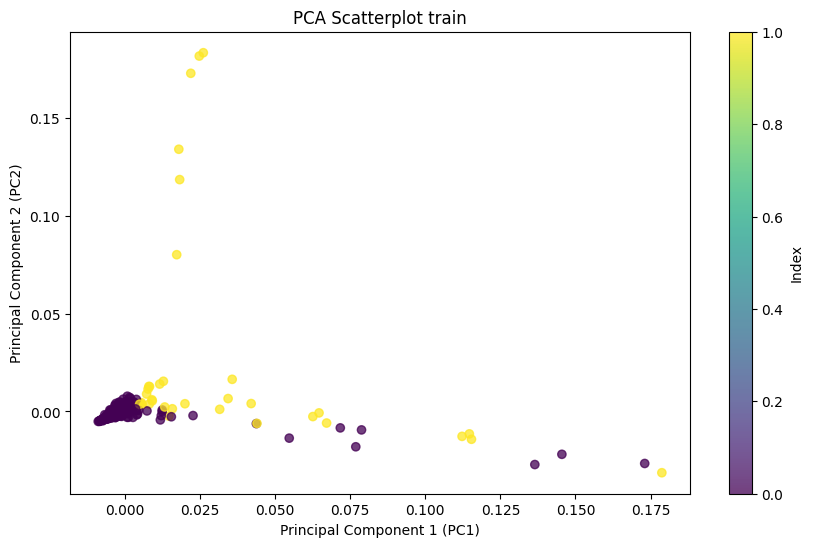

In [91]:
# Plotting train_result_df with ground truth labels
plt.figure(figsize=(10, 6))
plt.scatter(train_result_df['PC1'], train_result_df['PC2'], c=train_result_df['label'], cmap='viridis', alpha=0.75)
plt.title('PCA Scatterplot train')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.colorbar(label='Index')

plt.show()

# plt.savefig(f'PCA_gridid_{grid_id}.jpg')

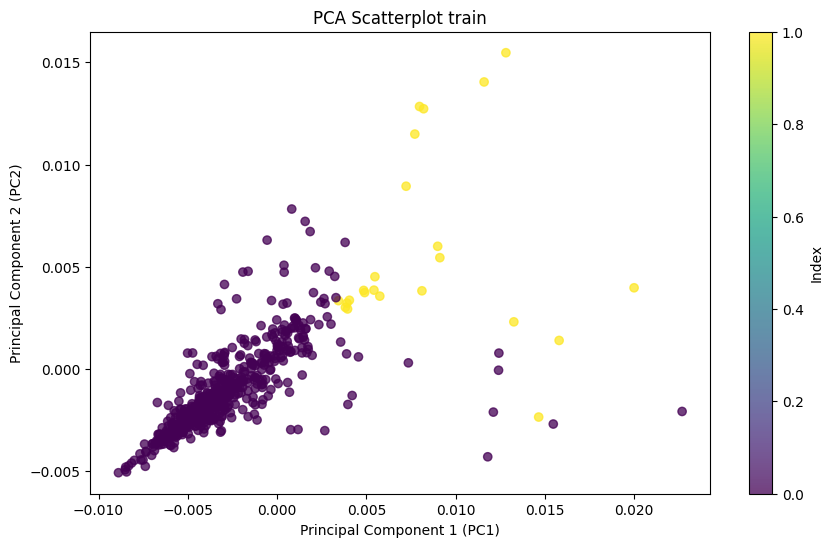

In [96]:
# Zoomed plot of pca_df with ground truth labels

train_result_df1 = train_result_df[train_result_df.PC1<0.025]
train_result_df1 = train_result_df1[train_result_df1.PC2<0.025]
# Plotting train_result_df with ground truth labels
plt.figure(figsize=(10, 6))
plt.scatter(train_result_df1['PC1'], train_result_df1['PC2'], c=train_result_df1['label'], cmap='viridis', alpha=0.75)
plt.title('PCA Scatterplot train')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.colorbar(label='Index')

plt.show()

# plt.savefig(f'PCA_gridid_{grid_id}.jpg')

In [92]:
test_result = pca_train.transform(X_test)

test_result_df = pd.DataFrame(data=test_result, columns=[f'PC{i+1}' for i in range(n_components)])

test_result_df.set_index(X_test.index)

# train_result_df['label'] = y_train
test_result_df = test_result_df.assign(label=y_test.values)


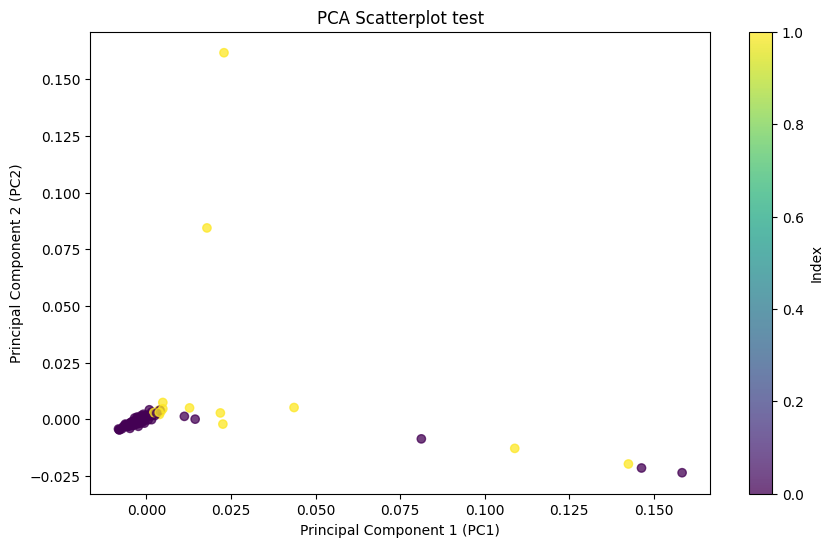

In [93]:
# Plotting train_result_df with ground truth labels
plt.figure(figsize=(10, 6))
plt.scatter(test_result_df['PC1'], test_result_df['PC2'], c=test_result_df['label'], cmap='viridis', alpha=0.75)
plt.title('PCA Scatterplot test')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.colorbar(label='Index')

plt.show()

# plt.savefig(f'PCA_gridid_{grid_id}.jpg')

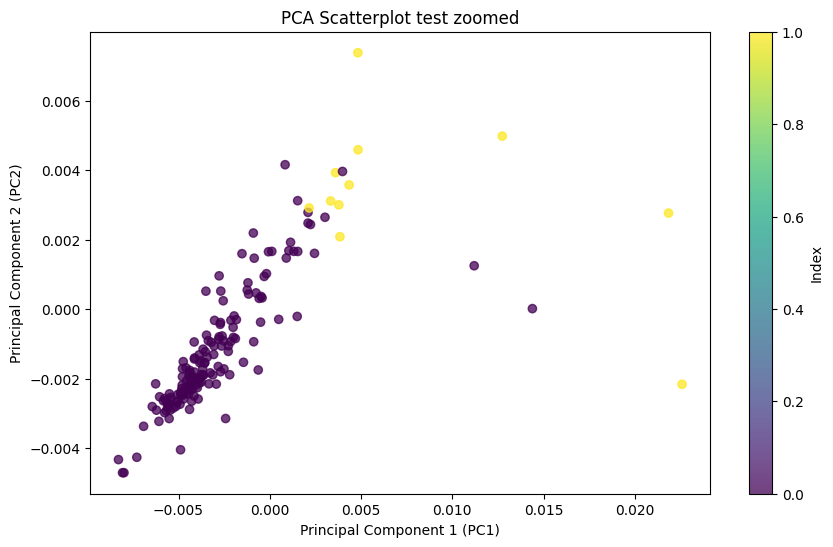

In [98]:
# Zoomed plot of pca_df with ground truth labels

test_result_df_1 = test_result_df[test_result_df.PC1<0.025]
test_result_df_1 = test_result_df_1[test_result_df_1.PC2<0.025]
plt.figure(figsize=(10, 6))
plt.scatter(test_result_df_1['PC1'], test_result_df_1['PC2'], c=test_result_df_1['label'], cmap='viridis', alpha=0.75)
plt.title('PCA Scatterplot test zoomed')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.colorbar(label='Index')

plt.show()

# plt.savefig(f'PCA_gridid_{grid_id}.jpg')

# 3b. Saving the trained PCA model

In [100]:
import pickle as pk
pk.dump(pca_train, open("pca_333519.pkl","wb"))

In [103]:
pca_reloaded = pk.load(open("pca_333519.pkl",'rb')) 
result_new = pca_reloaded.transform(X_test) # X_new is a new data sample

In [104]:
test_result = pca_reloaded.transform(X_test)

test_result_df = pd.DataFrame(data=test_result, columns=[f'PC{i+1}' for i in range(n_components)])

test_result_df.set_index(X_test.index)

# train_result_df['label'] = y_train
test_result_df = test_result_df.assign(label=y_test.values)

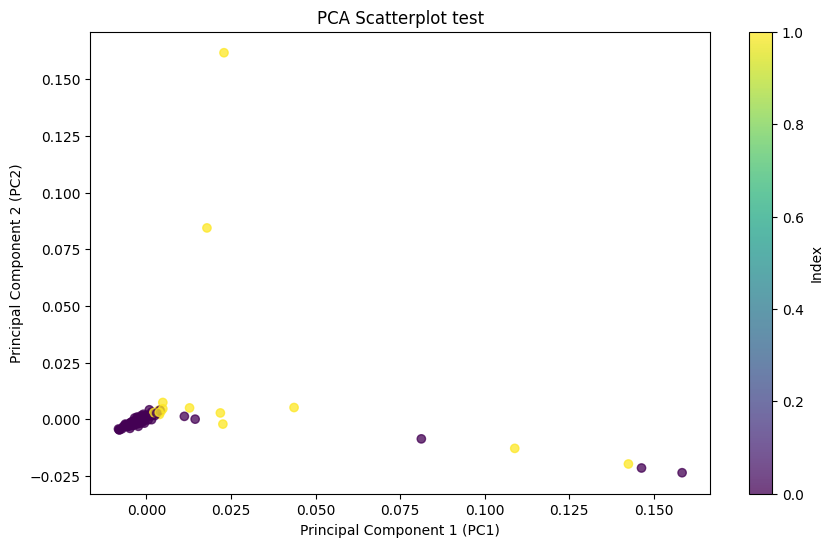

In [105]:
# Plotting train_result_df with ground truth labels
plt.figure(figsize=(10, 6))
plt.scatter(test_result_df['PC1'], test_result_df['PC2'], c=test_result_df['label'], cmap='viridis', alpha=0.75)
plt.title('PCA Scatterplot test')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.colorbar(label='Index')

plt.show()

# plt.savefig(f'PCA_gridid_{grid_id}.jpg')